[*********************100%***********************]  7 of 7 completed
C:\Users\marco\AppData\Local\Temp\ipykernel_28448\3626836726.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  banks_close_filled = banks_close.fillna(method='ffill').fillna(method='bfill')
C:\Users\marco\AppData\Local\Temp\ipykernel_28448\3626836726.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  banks_open_filled = banks_open.fillna(method='ffill').fillna(method='bfill')


Evaluating window sizes...


Evaluating Windows: 100%|██████████| 69/69 [00:00<00:00, 367.03it/s]


Best rolling window found: 39 days
Best Cumulative Return on Training Data: 416.14%
Applying capping and redistributing weights...
Capping turnover for different rebalance periods...
Calculating strategy returns...
Calculating daily costs...
Adjusting strategy returns with costs...
Calculating cumulative returns...
Calculating performance metrics...
Plotting cumulative returns...


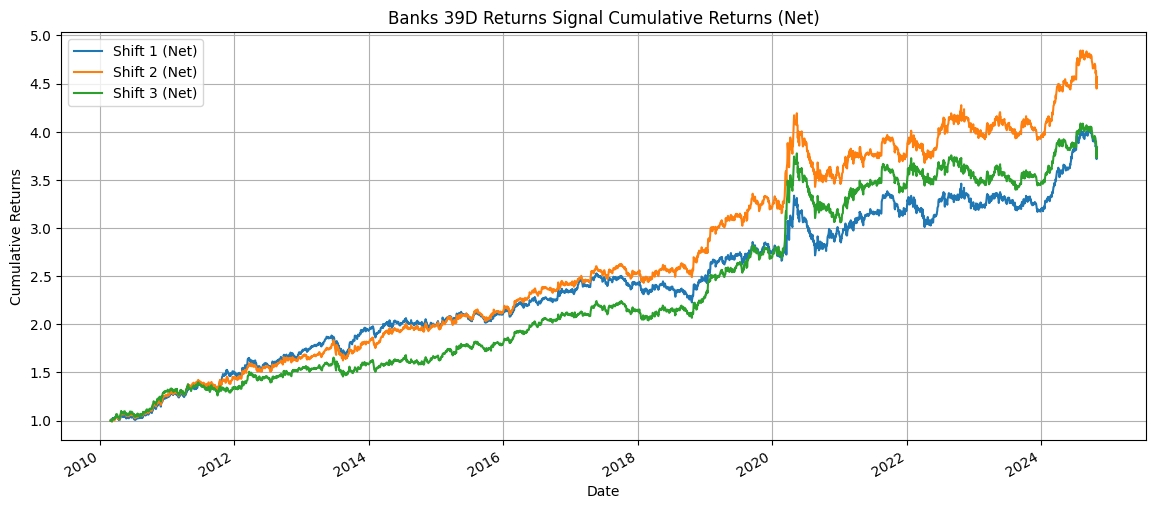

Displaying performance metrics...
Performance Metrics for Shift 1:
  Cumulative Return: 283.77%
  Annualized Return: 9.61%
  Annualized Volatility: 0.1159
  Sharpe Ratio: 0.8290
  Max Drawdown: -18.58%


Performance Metrics for Shift 2:
  Cumulative Return: 356.98%
  Annualized Return: 10.93%
  Annualized Volatility: 0.1147
  Sharpe Ratio: 0.9525
  Max Drawdown: -18.24%


Performance Metrics for Shift 3:
  Cumulative Return: 283.34%
  Annualized Return: 9.60%
  Annualized Volatility: 0.1155
  Sharpe Ratio: 0.8315
  Max Drawdown: -18.97%


Average Turnover (Shift 1): 0.2790
Average Turnover (Shift 2): 0.1398
Average Turnover (Shift 3): 0.0932
Average Daily Cost (Shift 1): 0.00027904
Average Daily Cost (Shift 2): 0.00013980
Average Daily Cost (Shift 3): 0.00009319
Plotting drawdowns...


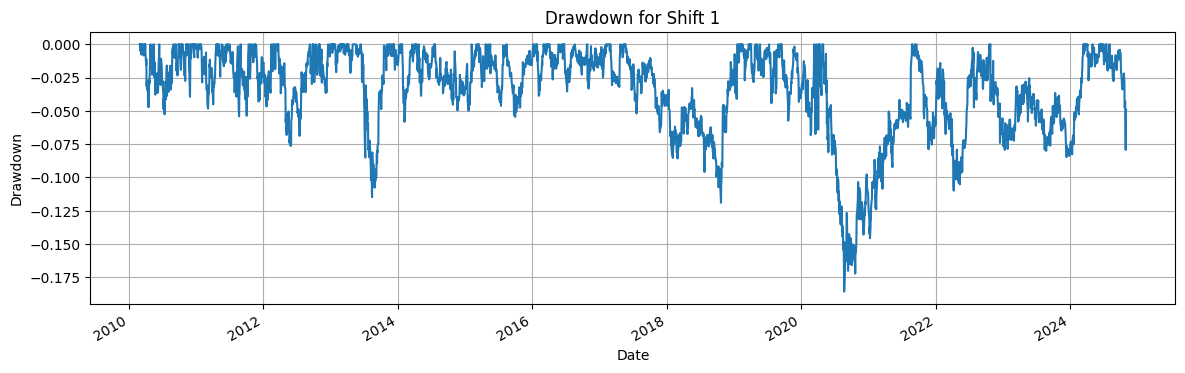

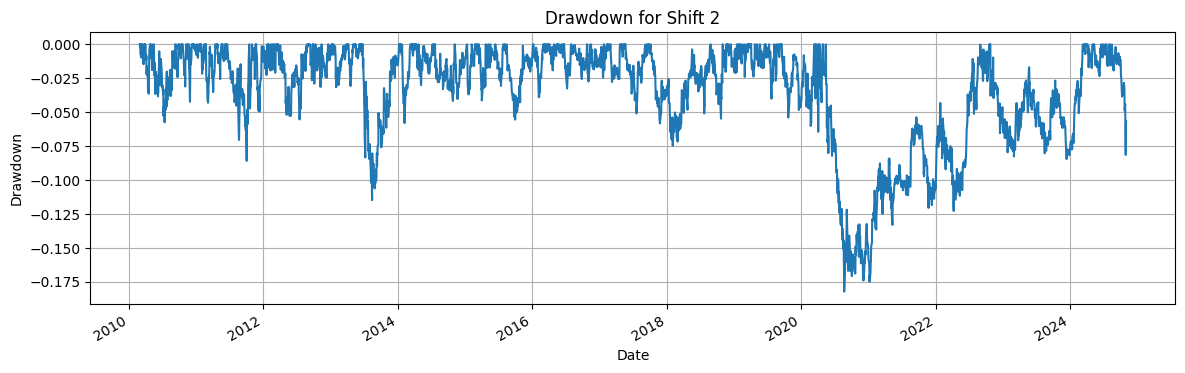

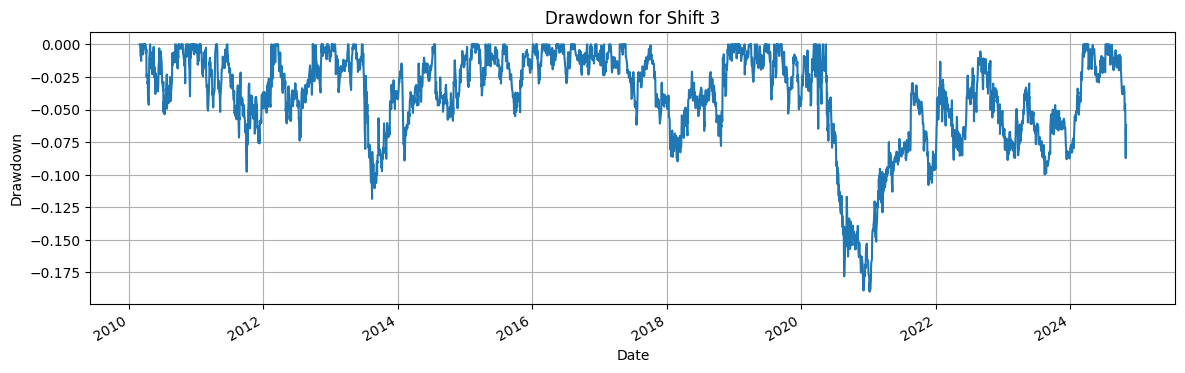

Backtest completed successfully.
Date
2010-03-01    0.000000
2010-03-02    0.009418
2010-03-03   -0.001807
2010-03-04    0.002295
2010-03-05   -0.004923
                ...   
2024-10-24    0.003511
2024-10-25    0.001639
2024-10-28   -0.038148
2024-10-29    0.027469
2024-10-30    0.005061
Length: 3694, dtype: float64


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm import tqdm

# Function to calculate performance metrics
def calculate_performance(cumulative_returns):
    daily_returns = cumulative_returns.pct_change().dropna()
    cumulative_return = cumulative_returns.iloc[-1] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(daily_returns)) - 1
    annualized_vol = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else np.nan
    max_drawdown = (cumulative_returns / cumulative_returns.cummax()).min() - 1
    return {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# List of tickers for the selected companies
banks_tickers = ['FI','LOW','MAS','GPK','LEN','DHI','SHW']

end_date = '2025-01-01'

# Download historical data
print("Downloading historical data...")
banks_data = yf.download(
    banks_tickers,
    start='2010-01-01',
    end=end_date,
    actions=False,
    auto_adjust=True
)

# Extract 'Close' and 'Open' prices
banks_close = banks_data['Close']
banks_open = banks_data['Open']

# Fill missing data
banks_close_filled = banks_close.fillna(method='ffill').fillna(method='bfill')
banks_open_filled = banks_open.fillna(method='ffill').fillna(method='bfill')

# Remove timezone info
banks_close_filled.index = banks_close_filled.index.tz_localize(None)
banks_open_filled.index = banks_open_filled.index.tz_localize(None)

# Calculate open-to-open returns
banks_rets = banks_open_filled.pct_change().shift(-1).dropna()

# Calculate close-to-close returns for signals
signals_rets = banks_close_filled.pct_change().fillna(0).iloc[:-1]

# Parameters
AUM = 20000000  # $20,000,000
fixed_fee_per_ticker = 0.00  # $0.35 per ticker
slippage_rate = 0.000  # 0.05%
window_range = range(30, 99)
train_ratio = 0.60  # 60% for training, 

# Split the data for walk-forward optimization
split_point = int(train_ratio * len(banks_rets))
training_data = banks_rets.iloc[:split_point]
validation_data = banks_rets.iloc[split_point:]

# Initialize variables
best_window = None
best_cumulative_return = -float('inf')

print("Evaluating window sizes...")
# Iterate through the window range with a progress bar
for window in tqdm(window_range, desc="Evaluating Windows"):
    rets_signal_train = -(
        training_data.rolling(window).sum().subtract(
            training_data.rolling(window).sum().mean(axis=1), axis=0
        )
    )
    rets_signal_train = rets_signal_train.divide(
        rets_signal_train.abs().sum(axis=1).replace(0, np.nan), axis=0
    ).dropna()

    strategy_returns = rets_signal_train.shift(1).multiply(training_data).sum(axis=1)
    cumulative_return = (1 + strategy_returns).prod() - 1

    if cumulative_return > best_cumulative_return:
        best_cumulative_return = cumulative_return
        best_window = window

print(f'Best rolling window found: {best_window} days')
print(f'Best Cumulative Return on Training Data: {best_cumulative_return:.2%}')

# Continue with the rest of the backtest using the best_window
# (The remaining code remains largely the same)

# Apply best window on entire dataset
rets_signal = -(
    signals_rets.rolling(best_window).sum().subtract(
        signals_rets.rolling(best_window).sum().mean(axis=1), axis=0
    )
)
rets_signal = rets_signal.divide(
    rets_signal.abs().sum(axis=1).replace(0, np.nan), axis=0
).dropna()

# Function to cap weights and redistribute excess
def cap_and_redistribute(weights, cap=0.50):
    weights = weights.copy()
    over_cap = weights > cap
    under_cap = weights < -cap

    # Excess weights
    excess_over = weights[over_cap] - cap
    excess_under = weights[under_cap] + cap  # Since weights[under_cap] < -cap

    # Cap the weights
    weights[over_cap] = cap
    weights[under_cap] = -cap

    # Total excess to redistribute
    excess_long = excess_over.sum()
    excess_short = excess_under.sum()

    # Remaining positions (excluding the ones capped)
    remaining_longs = weights > 0
    remaining_shorts = weights < 0

    # Exclude positions that were capped
    remaining_longs[over_cap] = False
    remaining_shorts[under_cap] = False

    sum_remaining_longs = weights[remaining_longs].sum()
    sum_remaining_shorts = weights[remaining_shorts].sum()

    # Distribute excess_long to remaining_longs proportionally
    if sum_remaining_longs != 0 and excess_long != 0:
        weights[remaining_longs] += (weights[remaining_longs] / sum_remaining_longs) * excess_long

    # Distribute excess_short to remaining_shorts proportionally
    if sum_remaining_shorts != 0 and excess_short != 0:
        weights[remaining_shorts] += (weights[remaining_shorts] / sum_remaining_shorts) * excess_short

    return weights

print("Applying capping and redistributing weights...")
# Apply the capping function to the signals
rets_signal_capped = rets_signal.apply(cap_and_redistribute, axis=1)

# Shift positions for different rebalance periods
positions_shift1 = rets_signal_capped.shift(1).fillna(0)
positions_shift2 = rets_signal_capped.shift(2).fillna(0)
positions_shift3 = rets_signal_capped.shift(3).fillna(0)

# Function to cap turnover per rebalance period
def cap_turnover(positions, max_turnover=0.50):
    adjusted_positions = positions.copy()
    dates = positions.index
    previous_positions = pd.Series(0, index=positions.columns)

    for date in dates:
        current_positions = positions.loc[date]
        delta_positions = current_positions - previous_positions
        total_turnover = delta_positions.abs().sum()

        if total_turnover <= max_turnover:
            adjusted_positions.loc[date] = current_positions
        else:
            scaling_factor = max_turnover / total_turnover
            scaled_delta_positions = delta_positions * scaling_factor
            adjusted_positions.loc[date] = previous_positions + scaled_delta_positions

        previous_positions = adjusted_positions.loc[date]

    return adjusted_positions

print("Capping turnover for different rebalance periods...")
# Apply turnover cap to positions
adjusted_positions_shift1 = cap_turnover(positions_shift1, max_turnover=0.90)
adjusted_positions_shift2 = cap_turnover(positions_shift2, max_turnover=0.99)
adjusted_positions_shift3 = cap_turnover(positions_shift3, max_turnover=0.99)

# Align positions and returns
aligned_positions_shift1, aligned_banks_rets = adjusted_positions_shift1.align(banks_rets, join='inner')
aligned_positions_shift2, _ = adjusted_positions_shift2.align(banks_rets, join='inner')
aligned_positions_shift3, _ = adjusted_positions_shift3.align(banks_rets, join='inner')

# Calculate strategy returns
print("Calculating strategy returns...")
strategy_returns_shift1 = aligned_positions_shift1.multiply(aligned_banks_rets).sum(axis=1)
strategy_returns_shift2 = aligned_positions_shift2.multiply(aligned_banks_rets).sum(axis=1)
strategy_returns_shift3 = aligned_positions_shift3.multiply(aligned_banks_rets).sum(axis=1)

# Calculate turnover per rebalance period
turnover_shift1 = adjusted_positions_shift1.diff().abs().sum(axis=1)
turnover_shift2 = adjusted_positions_shift2.diff().abs().sum(axis=1)
turnover_shift3 = adjusted_positions_shift3.diff().abs().sum(axis=1)

# Calculate average daily turnover
average_daily_turnover_shift1 = turnover_shift1
average_daily_turnover_shift2 = turnover_shift2 / 2
average_daily_turnover_shift3 = turnover_shift3 / 3

# Calculate costs
def calculate_daily_cost(rebalance_period, turnover):
    num_tickers = len(banks_tickers)
    fixed_fee = ((fixed_fee_per_ticker * num_tickers) / rebalance_period) / AUM
    slippage_cost = slippage_rate * (turnover / rebalance_period)
    return fixed_fee + slippage_cost

print("Calculating daily costs...")
daily_cost_shift1 = calculate_daily_cost(1, turnover_shift1)
daily_cost_shift2 = calculate_daily_cost(2, turnover_shift2)
daily_cost_shift3 = calculate_daily_cost(3, turnover_shift3)

# Adjust strategy returns with costs
print("Adjusting strategy returns with costs...")
net_strategy_returns_shift1 = strategy_returns_shift1 - daily_cost_shift1
net_strategy_returns_shift2 = strategy_returns_shift2 - daily_cost_shift2
net_strategy_returns_shift3 = strategy_returns_shift3 - daily_cost_shift3

# Calculate cumulative returns with costs
print("Calculating cumulative returns...")
cumulative_rets_shift1 = (1 + net_strategy_returns_shift1).cumprod()
cumulative_rets_shift2 = (1 + net_strategy_returns_shift2).cumprod()
cumulative_rets_shift3 = (1 + net_strategy_returns_shift3).cumprod()

# Calculate performance metrics
print("Calculating performance metrics...")
performance_shift1 = calculate_performance(cumulative_rets_shift1)
performance_shift2 = calculate_performance(cumulative_rets_shift2)
performance_shift3 = calculate_performance(cumulative_rets_shift3)

# Plot cumulative returns with costs
print("Plotting cumulative returns...")
plt.figure(figsize=(14, 6))
cumulative_rets_shift1.plot(label='Shift 1 (Net)', grid=True)
cumulative_rets_shift2.plot(label='Shift 2 (Net)', grid=True)
cumulative_rets_shift3.plot(label='Shift 3 (Net)', grid=True)
plt.title(f'Banks {best_window}D Returns Signal Cumulative Returns (Net)')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Display performance metrics
def display_performance(perf, label):
    print(f"Performance Metrics for {label}:")
    for key, value in perf.items():
        if 'Return' in key or 'Drawdown' in key:
            print(f"  {key}: {value:.2%}")
        else:
            print(f"  {key}: {value:.4f}")
    print("\n")

print("Displaying performance metrics...")
display_performance(performance_shift1, "Shift 1")
display_performance(performance_shift2, "Shift 2")
display_performance(performance_shift3, "Shift 3")

# Display average turnover and costs
print(f"Average Turnover (Shift 1): {average_daily_turnover_shift1.mean():.4f}")
print(f"Average Turnover (Shift 2): {average_daily_turnover_shift2.mean():.4f}")
print(f"Average Turnover (Shift 3): {average_daily_turnover_shift3.mean():.4f}")
print(f"Average Daily Cost (Shift 1): {daily_cost_shift1.mean():.8f}")
print(f"Average Daily Cost (Shift 2): {daily_cost_shift2.mean():.8f}")
print(f"Average Daily Cost (Shift 3): {daily_cost_shift3.mean():.8f}")

# Optional: Plot drawdowns
def plot_drawdown(cumulative_returns, label):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    plt.figure(figsize=(14, 4))
    drawdown.plot(title=f'Drawdown for {label}')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True)
    plt.show()

print("Plotting drawdowns...")
plot_drawdown(cumulative_rets_shift1, "Shift 1")
plot_drawdown(cumulative_rets_shift2, "Shift 2")
plot_drawdown(cumulative_rets_shift3, "Shift 3")

print("Backtest completed successfully.")
print(net_strategy_returns_shift1)
